# Test quality of initial field distribution

- check Meep's integration routine
- check implementation of Laguerre-Gauss beam fields
- check transition from cartesian to spherical coordinates

In [1]:
import math
import numpy as np
import scipy as sp

π = np.pi

from scipy.integrate import dblquad

def complex_dblquad(func, a, b, gfun, hfun, **kwargs):
    """Integrates the real and imaginary part of the given function."""
    def real_func(x, y):
        return sp.real(func(x, y))
    def imag_func(x, y):
        return sp.imag(func(x, y))
    
    def real_integral():
        return dblquad(real_func, a, b, gfun, hfun, **kwargs)
    def imag_integral():
        return dblquad(imag_func, a, b, gfun, hfun, **kwargs)
    
    return (real_integral()[0] + 1j * imag_integral()[0], real_integral()[1:], imag_integral()[1:])


def f_Gauss_cartesian(W_y, k_y, k_z): 
    """
    """
    return sp.exp(-(W_y ** 2) * (k_y ** 2 + k_z ** 2) / 4)

def f_Gauss_spherical(W_y, sin_theta):
    """
    """
    return sp.exp(-((k1 * W_y) * sin_theta / 2) ** 2)

def f_Laguerre_Gauss_cartesian(W_y, m, k_y, k_z):
    """
    """
    k_x = sp.sqrt(k1**2 - k_y**2 - k_z**2)
    
    ϕ = math.atan2(k_y / k1, -k_z / k1)
    θ = math.acos(k_x / k1)
    
    return f_Gauss_cartesian(W_y, k_y, k_z) * (θ ** abs(m)) * sp.exp(1j * m * ϕ)

def f_Laguerre_Gauss_spherical(W_y, m, sin_theta, θ, ϕ):
    """
    """
    return f_Gauss_spherical(W_y, sin_theta) * (θ ** abs(m)) * sp.exp(1j * m * ϕ)

def integrand_cartesian(x, y, z, k_y, k_z):
    """
    """
    ## first variant (taking the real part of the square root)
    #return f_Gauss_cartesian(w_0, k_y, k_z) * sp.exp(1.0j * (x * (sp.sqrt(k**2 - k_y**2 - k_z**2).real) + 
    #                                                         y * k_y + 
    #                                                         z * k_z))
    
    ## second variant (leave square root as is, but perform second integration with non-constant bounds)
    ## Gauss
    #k_x = sp.sqrt(k1**2 - k_y**2 - k_z**2)
    #return f_Gauss_cartesian(w_0, k_y, k_z) * sp.exp(1.0j * (x * k_x + y * k_y + z * k_z))
    
    ## Laguerre-Gauss
    k_x = sp.sqrt(k1**2 - k_y**2 - k_z**2)
    return f_Laguerre_Gauss_cartesian(w_0, m_charge, k_y, k_z) * sp.exp(1j * (x * k_x + y * k_y + z * k_z))


def integrand_spherical(x, y, z, θ, ϕ):
    """
    """
    sin_theta = math.sin(θ)
    cos_theta = math.cos(θ)
    return sin_theta * cos_theta * f_Laguerre_Gauss_spherical(w_0, m_charge, sin_theta, θ, ϕ) * \
           sp.exp(1j * k1 * (sin_theta * (y * math.sin(ϕ) - z * math.cos(ϕ)) + cos_theta * x))

def psi_cartesian(x, y, z):
    """
    """
    integrand_ = lambda k_y, k_z: integrand_cartesian(x, y, z, k_y, k_z)
    
    ## constant integration bounds (appropriate for first variant)
    #return complex_dblquad(integrand_, -k1, k1, lambda x: -k1, lambda x: k1)[0]
    
    ## non-constant integration bounds (appropriate for second variant)
    return complex_dblquad(integrand_, -k1, k1, lambda x: -np.sqrt(k1**2 - x**2), lambda x: np.sqrt(k1**2 - x**2))[0]
    
def psi_spherical(x, y, z):
    """
    """
    integrand_ =  lambda ϕ, θ: integrand_spherical(x, y, z, θ, ϕ)
    
    return (k1 ** 2) * complex_dblquad(integrand_, 0.0, π/2, lambda x: 0.0, lambda x: 2*π)[0]
    
vec_psi_cartesian = np.vectorize(psi_cartesian)
vec_psi_spherical = np.vectorize(psi_spherical)

In [2]:
## test parameters (free space propagation, i.e. n1=n2=n_ref=1)
kw_0     = 8
m_charge = 2
n1       = 1

## meep specific
freq    = 5
x_shift = -2.15

## derived values
k_vac = 2 * np.pi * freq
k1    = n1 * k_vac
w_0   = kw_0 / k_vac

## test values
k_y = 1.0
k_z = 5.2
k_x = sp.sqrt(k1**2 - k_y**2 - k_z**2)

x = x_shift
y = 0.3
z = 0.5

ϕ = math.atan2(k_y/k1, -k_z/k1)
θ = math.acos(k_x/k1)

print("Gauss spectrum (cartesian): ", f_Gauss_cartesian(W_y=w_0, k_y=k_y, k_z=k_z))
print("Gauss spectrum (spherical): ", f_Gauss_spherical(W_y=w_0, sin_theta=math.sin(θ)))
print("\n")
print("L-G spectrum   (cartesian): ", f_Laguerre_Gauss_cartesian(W_y=w_0, m=m_charge, k_y=k_y, k_z=k_z))
print("L-G spectrum   (spherical): ", f_Laguerre_Gauss_spherical(W_y=w_0, m=m_charge, sin_theta=math.sin(θ), θ=θ, ϕ=ϕ))
print("\n")
print("integrand      (cartesian): ", integrand_cartesian(x=x_shift, y=y, z=z, k_y=k_y, k_z=k_z))
print("integrand      (spherical): ", integrand_spherical(x=x_shift, y=y, z=z, θ=θ, ϕ=ϕ))
print("\n")
%time print("psi            (cartesian): ", psi_cartesian(x=x_shift, y=y, z=z))
%time print("psi            (spherical): ", psi_spherical(x=x_shift, y=y, z=z))

Gauss spectrum (cartesian):  0.6347225159862774
Gauss spectrum (spherical):  0.6347225159862802


L-G spectrum   (cartesian):  (0.016907581994799106-0.006752644114666309j)
L-G spectrum   (spherical):  (0.01690758199479918-0.006752644114666338j)


integrand      (cartesian):  (0.006154277991170235-0.017134450497684195j)
integrand      (spherical):  (0.0010224866747089406-0.002846759171015585j)


psi            (cartesian):  (0.6062810704686634-1.7444288209294596j)
CPU times: user 1min 16s, sys: 60.1 ms, total: 1min 17s
Wall time: 1min 17s
psi            (spherical):  (0.6062810703699058-1.7444288201684213j)
CPU times: user 4.96 s, sys: 4.01 ms, total: 4.96 s
Wall time: 4.98 s


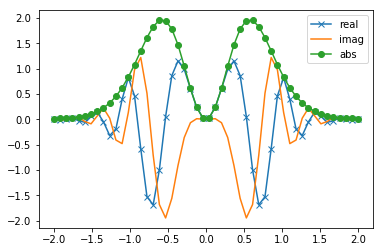

CPU times: user 690 ms, sys: 132 ms, total: 822 ms
Wall time: 1.93 s


In [3]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt

#-----------------------------------
#K_y = np.linspace(-k1, k1, 100)
#INTEGRAND = integrand_cartesian(x_shift, 0.0, 0.0, K_y, 0.0)
#plt.plot(K_y, INTEGRAND.real)
#plt.plot(K_y, INTEGRAND.imag)

Z = np.linspace(-2, 2, 50)

try:
    PSI = np.load('PSI.npy')
except FileNotFoundError:
    PSI = vec_psi_spherical(-2.0, 0.0, Z)   # at origin
    np.save('PSI.npy', PSI)
    

#np.save('PSIz_spherical_m_2_x_-2.npy', PSI)
#PSI = np.load('PSI_cartesian.npy')

#np.save('PSIy_spherical_m_2.npy', PSI)
#PSI = np.load('PSIy_spherical_m_2.npy')

#print(PSI)

plt.plot(Z, PSI.real,    label='real', marker='x')
plt.plot(Z, PSI.imag,    label='imag')
plt.plot(Z, np.abs(PSI), label='abs', marker='o')
plt.legend()
plt.show();